In [3]:
TRAIN_DATA_DIR = "chest_xray/train"
VAL_DATA_DIR = "chest_xray/val"
TEST_DATA_DIR = "chest_xray/test"

In [4]:
# Define data directories for all sets
data_dirs = {
    'train': TRAIN_DATA_DIR,
    'val': VAL_DATA_DIR,
    'test': TEST_DATA_DIR
}

In [5]:
import os

# Function to analyze dataset distribution
def print_dataset_stats(data_dirs):
    total_normal = 0
    total_pneumonia = 0
    
    print("Dataset Distribution:")
    print("-" * 50)
    
    for dataset_type, dir_path in data_dirs.items():
        normal_path = os.path.join(dir_path, 'NORMAL')
        pneumonia_path = os.path.join(dir_path, 'PNEUMONIA')
        
        normal_count = len(os.listdir(normal_path))
        pneumonia_count = len(os.listdir(pneumonia_path))
        
        total_normal += normal_count
        total_pneumonia += pneumonia_count
        
        print(f"{dataset_type.capitalize()} set:")
        print(f"  Normal X-Rays: {normal_count}")
        print(f"  Pneumonia X-Rays: {pneumonia_count}")
        print(f"  Ratio (Pneumonia/Normal): {pneumonia_count/normal_count:.2f}")
        print()
    
    print("Overall Statistics:")
    print(f"Total Normal cases: {total_normal}")
    print(f"Total Pneumonia cases: {total_pneumonia}")
    print(f"Total images: {total_normal + total_pneumonia}")

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

def plot_sample_images(data_dirs, samples_per_class=5):
    for dataset_type, dir_path in data_dirs.items():
        normal_path = os.path.join(dir_path, 'NORMAL')
        pneumonia_path = os.path.join(dir_path, 'PNEUMONIA')
        
        normal_samples = np.random.choice(os.listdir(normal_path), samples_per_class, replace=False)
        pneumonia_samples = np.random.choice(os.listdir(pneumonia_path), samples_per_class, replace=False)
        
        fig, axes = plt.subplots(2, samples_per_class, figsize=(20, 8))
        fig.suptitle(f'Sample Images from {dataset_type.capitalize()} Set', fontsize=16)
        
        for idx, (norm_img, pneu_img) in enumerate(zip(normal_samples, pneumonia_samples)):
            # Plot normal images
            norm_img_path = os.path.join(normal_path, norm_img)
            img = Image.open(norm_img_path)
            axes[0, idx].imshow(img, cmap='gray')
            axes[0, idx].axis('off')
            axes[0, idx].set_title('Normal')
            
            # Plot pneumonia images
            pneu_img_path = os.path.join(pneumonia_path, pneu_img)
            img = Image.open(pneu_img_path)
            axes[1, idx].imshow(img, cmap='gray')
            axes[1, idx].axis('off')
            axes[1, idx].set_title('Pneumonia')
        
        plt.tight_layout()
        plt.show()

Dataset Distribution:
--------------------------------------------------
Train set:
  Normal X-Rays: 1341
  Pneumonia X-Rays: 3876
  Ratio (Pneumonia/Normal): 2.89

Val set:
  Normal X-Rays: 8
  Pneumonia X-Rays: 8
  Ratio (Pneumonia/Normal): 1.00

Test set:
  Normal X-Rays: 234
  Pneumonia X-Rays: 390
  Ratio (Pneumonia/Normal): 1.67

Overall Statistics:
Total Normal cases: 1583
Total Pneumonia cases: 4274
Total images: 5857


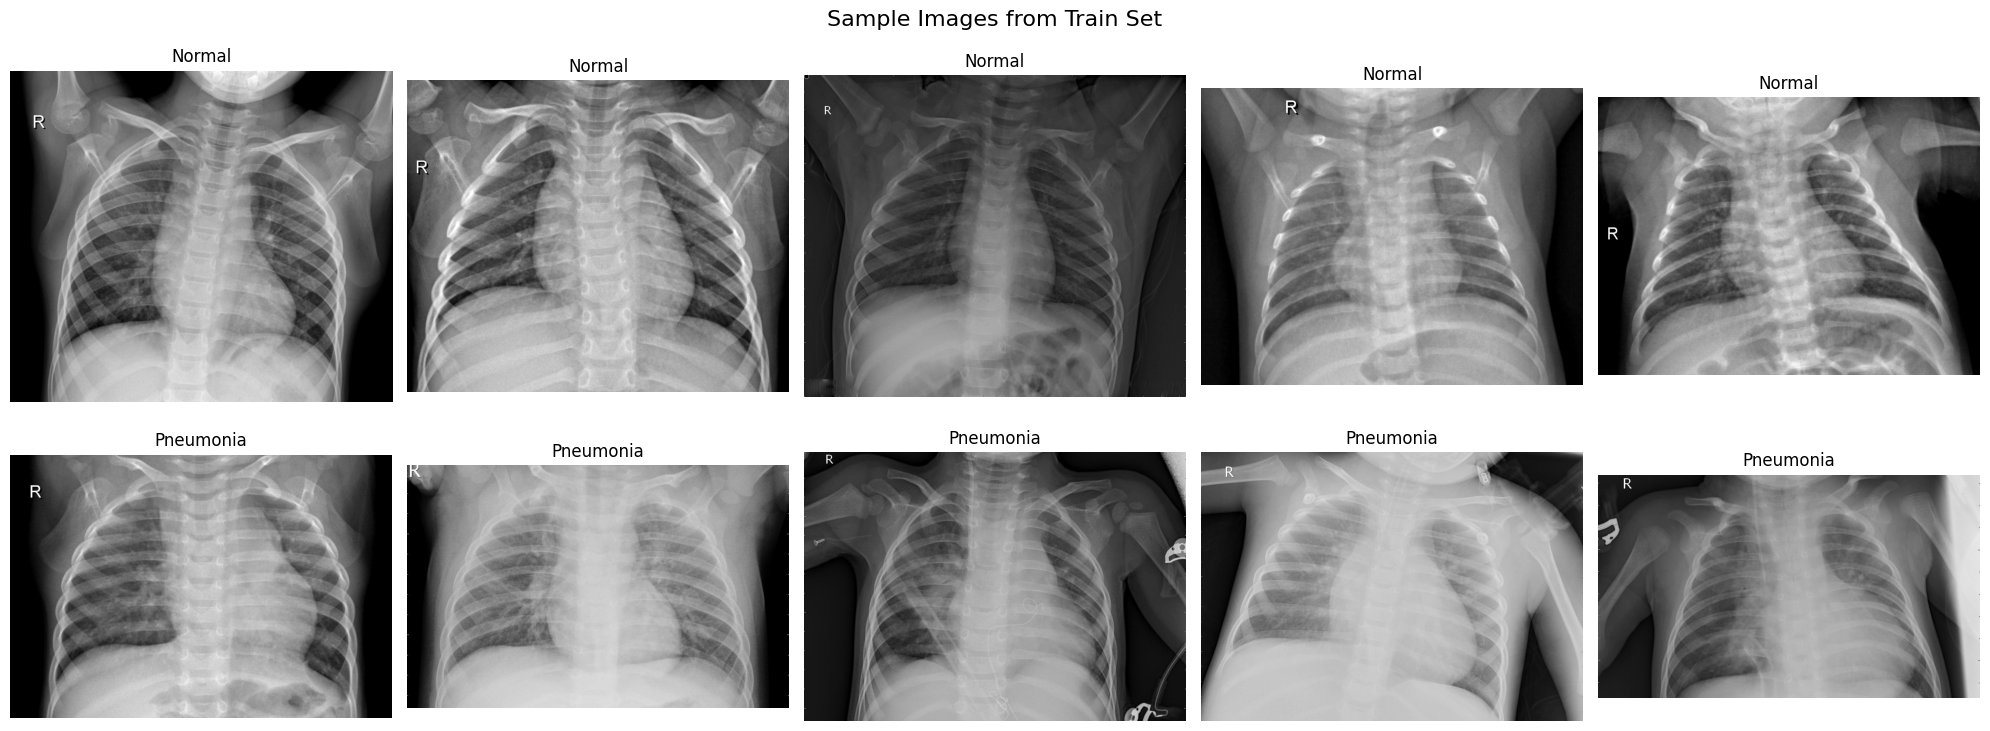

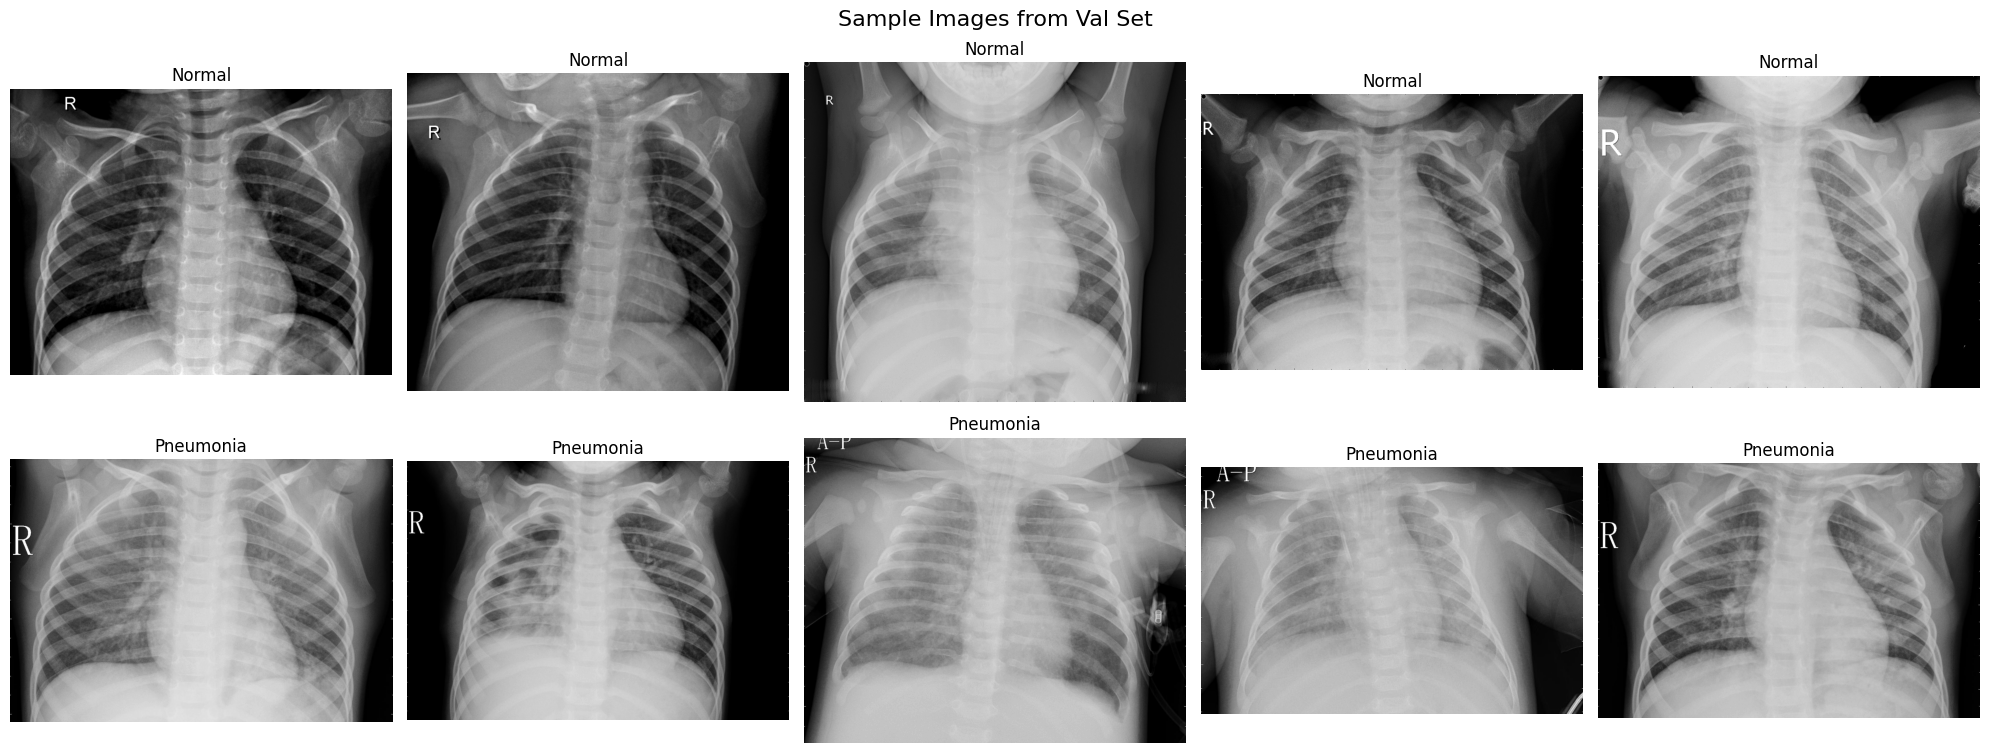

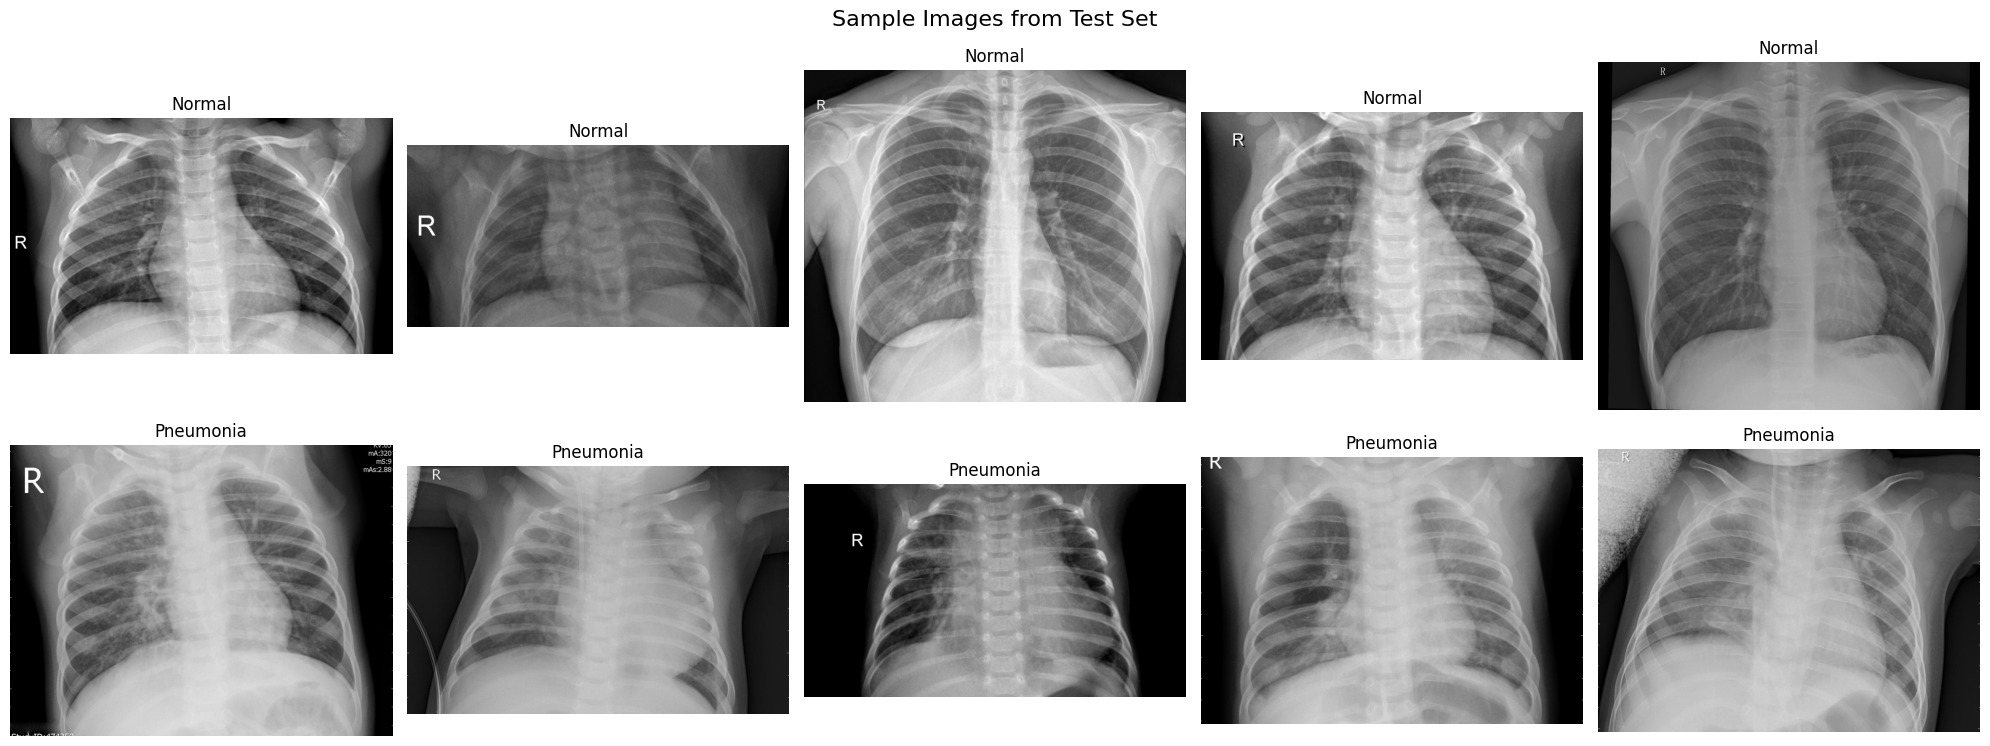

In [7]:
print_dataset_stats(data_dirs)
plot_sample_images(data_dirs)

In [8]:
# Image parameters
IMG_SIZE = (128, 128)
IMG_CHANNELS = 3
BATCH_SIZE = 32

In [9]:
import tensorflow as tf

# Define data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.Normalization()
])

2024-11-14 04:39:52.147878: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-14 04:39:52.147926: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
# Function to prepare datasets
def prepare_dataset(directory, subset=None):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        validation_split=0.2 if subset in ['training', 'validation'] else None,
        subset=subset,
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='binary',
        shuffle=True if subset in ['training', 'validation'] else False
    )

In [11]:
# Create datasets
train_dataset = prepare_dataset(data_dirs['train'], subset='training')
val_dataset = prepare_dataset(data_dirs['train'], subset='validation')
test_dataset = prepare_dataset(data_dirs['test'])

# Adapt the normalization layer to the training data
normalization_layer = tf.keras.layers.Normalization()
normalization_layer.adapt(train_dataset.map(lambda x, y: x))

# Apply data augmentation and normalization
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
val_dataset = val_dataset.map(lambda x, y: (data_augmentation(x, training=False), y))
test_dataset = test_dataset.map(lambda x, y: (data_augmentation(x, training=False), y))

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


2024-11-14 04:39:54.597412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [4173]
	 [[{{node Placeholder/_4}}]]
2024-11-14 04:39:54.597789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4173]
	 [[{{node Placeholder/_0}}]]
2024-11-14 04:39:54.724606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-14 04:39:54.759658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [12]:
from sklearn.utils import class_weight
import numpy as np

# Assuming you have access to all labels in the training set
y_train = np.concatenate([y for x, y in train_dataset], axis=0).flatten()
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

2024-11-14 04:40:05.062075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype float and shape [1,1,1,3]
	 [[{{node Placeholder/_22}}]]
2024-11-14 04:40:05.062634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_23' with dtype float and shape [1,1,1,3]
	 [[{{node Placeholder/_23}}]]
2024-11-14 04:40:05.115279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [13]:
class_weights

{0: 1.8831227436823104, 1: 0.6807504078303426}

In [14]:
from tensorflow.keras import layers, Sequential, regularizers

def initialize_model(name: str) -> Sequential:
    model = Sequential(name=name)

    # First Convolutional Block
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=IMG_SIZE + (IMG_CHANNELS,), padding='same', name='conv1'))
    model.add(layers.BatchNormalization(name='bn1'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(layers.Dropout(0.1, name='dropout1'))
    model.add(layers.Conv2D(32, (3, 3), activation="relu",
                          kernel_regularizer=regularizers.l2(0.001),
                          input_shape=IMG_SIZE + (IMG_CHANNELS,), padding='same', name='conv1'))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same', name='conv2'))
    model.add(layers.BatchNormalization(name='bn2'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2), name='pool2'))
    model.add(layers.Dropout(0.2, name='dropout2'))

    # Third Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same', name='conv3'))
    model.add(layers.BatchNormalization(name='bn3'))
    model.add(layers.MaxPooling2D(pool_size=(3, 3), name='pool3'))
    model.add(layers.Dropout(0.3, name='dropout3'))

    # Fully Connected Layers
    model.add(layers.Flatten(name='flatten'))
    model.add(layers.Dense(64, activation='relu', name='fc1'))
    model.add(layers.BatchNormalization(name='bn4'))
    model.add(layers.Dropout(0.5, name='dropout4'))
    model.add(layers.Dense(1, activation='sigmoid', name='output'))
    return model

In [15]:
model = initialize_model(name="basemodel")
model.summary()

Model: "basemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 4, 4, 1280)       4049571   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,213,668
Trainable params: 164,097
Non-trainable params: 4,049,571
_________________________________________

In [16]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred, eps, 1. - eps)
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1. - y_pred)
        return -tf.reduce_mean(alpha * tf.pow(1. - pt, gamma) * tf.math.log(pt))
    return focal_loss_fixed

In [17]:
def compile_model(model):
    model.compile(optimizer="adam",loss=focal_loss(),metrics="binary_accuracy")
    return model

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_baseline = initialize_model(name="baseline")
compiled_model = compile_model(model_baseline)
callbacks = [EarlyStopping(patience=5, monitor='val_binary_accuracy', restore_best_weights=True),
            ReduceLROnPlateau(monitor = 'val_loss', patience = 2, factor=0.5, verbose=1),
            ModelCheckpoint("xray_model.keras", save_best_only=True)]

In [19]:
history_baseline = compiled_model.fit(train_dataset,
                                      batch_size=BATCH_SIZE,
                                      epochs=10,
                                      validation_data=val_dataset,
                                      shuffle=True,
                                      callbacks=callbacks,
                                      class_weight=class_weights
                                      )

2024-11-14 04:40:31.111633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_22' with dtype float and shape [1,1,1,3]
	 [[{{node Placeholder/_22}}]]
2024-11-14 04:40:31.112157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_27' with dtype double and shape [2]
	 [[{{node Placeholder/_27}}]]
2024-11-14 04:40:31.162407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-14 04:40:31.256513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.

Epoch 1/10


2024-11-14 04:40:36.812125: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-14 04:40:37.161985: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp_2.


131/131 [==============================] - ETA: 0s - loss: 0.0664 - binary_accuracy: 0.6063

2024-11-14 04:41:07.541381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1043]
	 [[{{node Placeholder/_4}}]]
2024-11-14 04:41:07.541824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_19' with dtype float and shape [1,1,1,3]
	 [[{{node Placeholder/_19}}]]
2024-11-14 04:41:08.656871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [56]:
scores = model_baseline.evaluate(test_dataset)
scores

20/20 [==============================] - 2s 80ms/step - loss: 0.0682 - binary_accuracy: 0.7212


[0.06818616390228271, 0.7211538553237915]

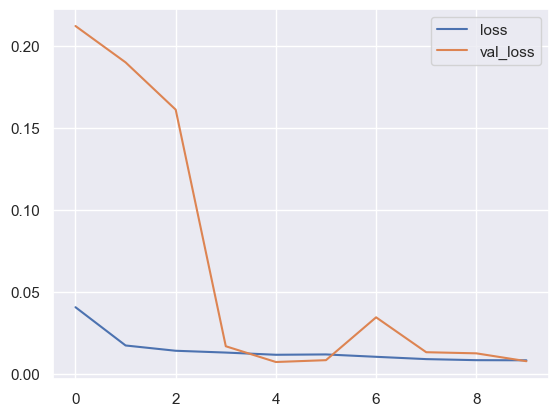

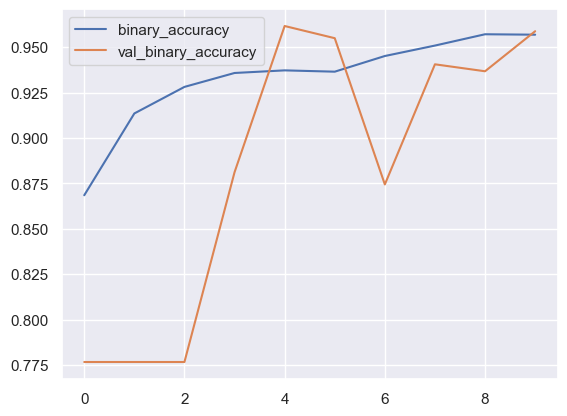

In [57]:
import pandas as pd
history_frame = pd.DataFrame(history_baseline.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [58]:
# Function to collect true labels and predictions
def get_predictions(model, dataset):
    true_labels = []
    predictions = []
    
    for batch in dataset:
        images, labels = batch
        preds = model.predict(images)
        preds = np.squeeze(preds)
        preds = (preds > 0.5).astype(int)
        
        true_labels.extend(labels.numpy())
        predictions.extend(preds)
    
    return np.array(true_labels), np.array(predictions)

# Get true labels and predictions
true_labels, predictions = get_predictions(model_baseline, test_dataset)

2024-11-14 04:34:06.606597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 235ms/step


2024-11-14 04:34:08.440150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [59]:
from sklearn.metrics import f1_score, classification_report
# Calculate F1 score
f1 = f1_score(true_labels, predictions)
print(f"F1 Score: {f1:.4f}")

# Optionally, print a detailed classification report
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=['Normal', 'Pneumonia']))

F1 Score: 0.8165

Classification Report:
              precision    recall  f1-score   support

      Normal       0.95      0.27      0.42       234
   Pneumonia       0.69      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.82      0.63      0.62       624
weighted avg       0.79      0.72      0.67       624



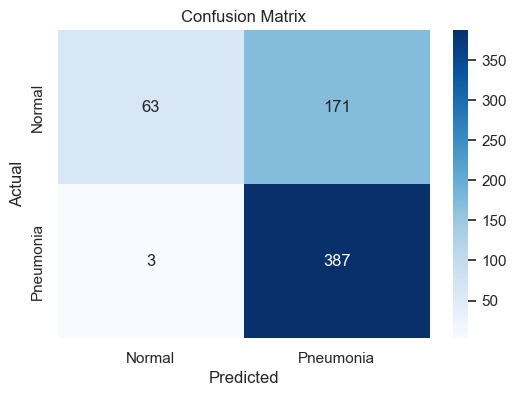

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()